In [1]:
# импортируем нужные функции и библиотеки

from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, make_scorer
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# Цель работы

Проверить освоение студентами всех этапов построение моделей машинного обучения.

# Содержание работы

**1. Выберите задачу для бизнеса, которую Вы хотите решить с помощью методов машинного обучения. На основание бизнес-задачи, поставьте задачу машинного обучения. Подберите дата-сет и оставьте ссылку на него.**

In [2]:
# загружаем датасет
data = fetch_openml('banknote-authentication')
print(data.DESCR)

Author: Volker Lohweg (University of Applied Sciences, Ostwestfalen-Lippe)  
Source: [UCI](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) - 2012  
Please cite: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html) 

Dataset about distinguishing genuine and forged banknotes. Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. A Wavelet Transform tool was used to extract features from these images.

### Attribute Information  

V1. variance of Wavelet Transformed image (continuous)  
V2. skewness of Wavelet Transformed image (continuous)  
V3. curtosis of Wavelet Transformed image (continuous)  
V4. entropy of image (continuous)  

Class (target). Presumably 1 for genuine 

**Описание**

*Бизнес-задача:* отличие подлинных банкнот от поддельных

*Информация об атрибутах:*
1. V1: Дисперсия изображения, преобразованного вейвлет-преобразованием (мера разброса цветов или яркости)
2. V2: Асимметрия вейвлет-преобразования изображения (отклонение от симметрии)
3. V3: Искажение вейвлет-преобразования изображения (дисторсия - нарушение геометрического подобия)
4. V4: Энтропия изображения (контраст, насыщенность)

*Вейвлет-преобразование* - интегральное преобразование фотографии в численные признаки

*Целевая переменная:* 1 - подлинник и 2 - подделка

*Ссылка:* https://openml.org/search?type=data&sort=nr_of_downloads&status=any&id=1462

In [3]:
# выводим датасет
data = data.frame
data

,V1,V2,V3,V4,Class
0,3.62160,8.66610,-2.8073,-0.44699,1
1,4.54590,8.16740,-2.4586,-1.46210,1
2,3.86600,-2.63830,1.9242,0.10645,1
3,3.45660,9.52280,-4.0112,-3.59440,1
4,0.32924,-4.45520,4.5718,-0.98880,1
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,2
1368,-1.38870,-4.87730,6.4774,0.34179,2
1369,-3.75030,-13.45860,17.5932,-2.77710,2
1370,-3.56370,-8.38270,12.3930,-1.28230,2


**2. Выполните анализ и обработку дата-сета. Этот задание включает в себя следующие этапы работы с данными:**
* Первичный анализ данных
* Предобработку данных
* Разведывательный анализ данных (Exploratory Data Analysis)
* Создание признаков (Feature Engineering)
* Отбор признаков (Feature selection)
* Подготовка данных (Data Preparation)

In [4]:
# типы атрибутов - есть категориальная целевая бинарная переменная, примененим get_dummies
data.info() # пропущенных значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      1372 non-null   float64 
 1   V2      1372 non-null   float64 
 2   V3      1372 non-null   float64 
 3   V4      1372 non-null   float64 
 4   Class   1372 non-null   category
dtypes: category(1), float64(4)
memory usage: 44.5 KB


In [5]:
# преобразуем бинарный класс банкнот
data['Class'] = pd.get_dummies(data['Class'], drop_first=True) # столбец по классу 2 - подделка или нет
data

,V1,V2,V3,V4,Class
0,3.62160,8.66610,-2.8073,-0.44699,False
1,4.54590,8.16740,-2.4586,-1.46210,False
2,3.86600,-2.63830,1.9242,0.10645,False
3,3.45660,9.52280,-4.0112,-3.59440,False
4,0.32924,-4.45520,4.5718,-0.98880,False
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,True
1368,-1.38870,-4.87730,6.4774,0.34179,True
1369,-3.75030,-13.45860,17.5932,-2.77710,True
1370,-3.56370,-8.38270,12.3930,-1.28230,True


In [6]:
# разделяем датасет на целевую переменную и атрибуты
X = data.drop(['Class'], axis = 1)
y = data['Class']

In [7]:
X.describe() # статистика по атрибутам

,V1,V2,V3,V4
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


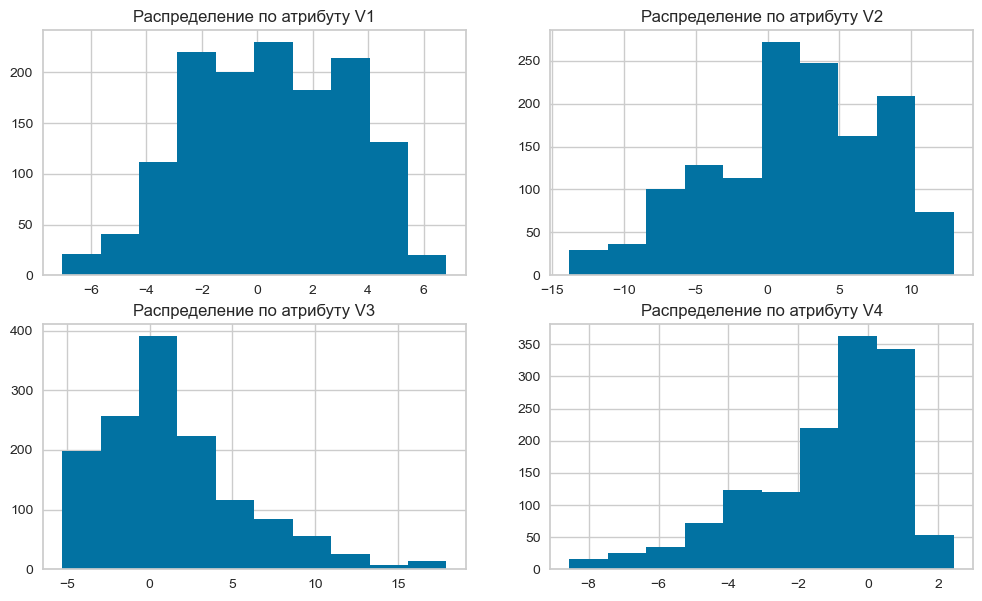

In [8]:
# распределение по атрибутам
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,7))
c = 0
coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in ['V1', 'V2', 'V3', 'V4']:
    current = coords[c]
    ax[current[0]][current[1]].set_title(f'Распределение по атрибуту {i}')
    ax[current[0]][current[1]].hist(X[i], 10)
    ax[current[0]][current[1]].grid(True)
    c += 1

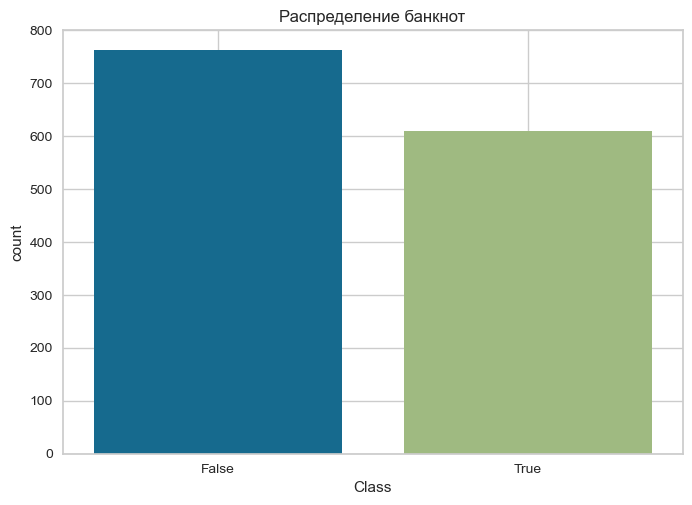

In [9]:
# распределение по банкнотам
plt.title('Распределение банкнот')
sns.countplot(x = y)
plt.grid(True)
plt.show()

In [10]:
# пустые значения по целевой переменной
y.isnull().sum()

0

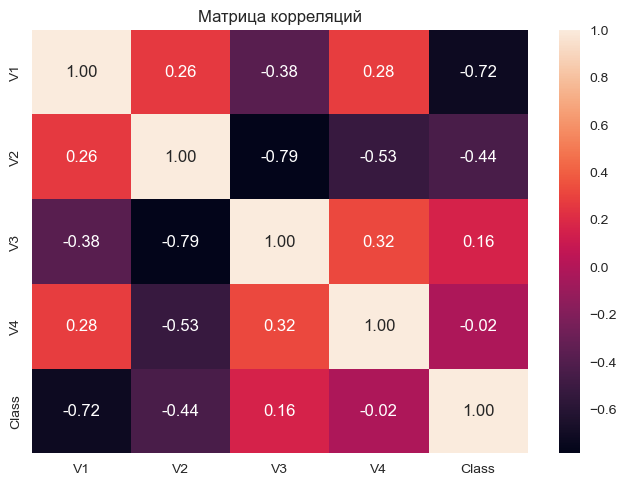

In [11]:
# матрица корреляций
plt.title('Матрица корреляций')
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

In [12]:
# полный перебор по атрибутам

selector = LogisticRegression(max_iter=1000)

efs1 = EFS(selector,
           min_features=1,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X, y)

Features: 15/15

In [13]:
# итоги перебора
subsets = efs1.subsets_
features = []
for i in subsets.keys():
    names = subsets[i]['feature_names']
    avg = subsets[i]['avg_score']
    features.append([names, avg])
sorted(features, key = lambda x: x[1])

[[('V4',), 0.5539376244193763],
 [('V3', 'V4'), 0.5954983410749835],
 [('V3',), 0.6129741207697412],
 [('V2',), 0.6494173855341738],
 [('V2', 'V4'), 0.7135713337757135],
 [('V2', 'V3'), 0.7667657597876576],
 [('V2', 'V3', 'V4'), 0.8083132050431321],
 [('V1',), 0.8447644326476444],
 [('V1', 'V3'), 0.8724565361645654],
 [('V1', 'V4'), 0.8753709356337094],
 [('V1', 'V2', 'V4'), 0.8775554080955541],
 [('V1', 'V2'), 0.8833948241539483],
 [('V1', 'V3', 'V4'), 0.9045175846051758],
 [('V1', 'V2', 'V3'), 0.9897969475779694],
 [('V1', 'V2', 'V3', 'V4'), 0.9897969475779694]]

In [14]:
# тест на значимость атрибутов
list(zip(X, SelectFromModel(DecisionTreeClassifier(), threshold = '0.3*mean').fit(X, y).get_support()))

[('V1', True), ('V2', True), ('V3', True), ('V4', False)]

In [15]:
# как оказалось V4 (атрибут энтропии) не оказал никакого влияния на метрику точности - он только добавляет "хаоса"
# к тому же V4 по одиночке даёт худшую точность и он незначим. Уберём данный признак
X_correct = X.drop(['V4'], axis = 1)
X_correct

,V1,V2,V3
0,3.62160,8.66610,-2.8073
1,4.54590,8.16740,-2.4586
2,3.86600,-2.63830,1.9242
3,3.45660,9.52280,-4.0112
4,0.32924,-4.45520,4.5718
...,...,...,...
1367,0.40614,1.34920,-1.4501
1368,-1.38870,-4.87730,6.4774
1369,-3.75030,-13.45860,17.5932
1370,-3.56370,-8.38270,12.3930


In [16]:
# делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_correct, y, test_size=0.1, stratify=y)

**3. Выберите несколько метрик для оценки моделей машинного обучения. Обоснуйте свой выбор и дайте интерпретацию метрик для бизнес-задачи.**

*accuracy* - точность предсказания модели. У нас небольшой дисбаланс классов, так что данная метрика имеет право на жизнь

*f1_score* - дополнение к метрике "точности" при дисбалансе классов. Учитывает в себе precision (точность) и recall (полноту)

*ROCAUC* - график, позволяющий оценить качество классификации. TPR - чувствительность алгоритма, FPR - специфичность

*confusion_matrix* - матрица ошибок. Показывет, сколько и как ошибается алгоритм в предсказаниях

**4. Постройте 4 модели машинного обучения для решение поставленной задачи.**

In [17]:
# функция по обучению модели и выведению метрик
def train_model(model):
    mod = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), confusion_matrix(y_test, y_pred)]
    visualizer = ROCAUC(model, classes = model.classes_)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    print(f"accuracy: {round(scores[0],3)}\nf1_score: {round(scores[1],3)}")
    sns.heatmap(scores[2], annot = True)
    plt.xlabel('True')
    plt.ylabel('Pred')
    plt.show()

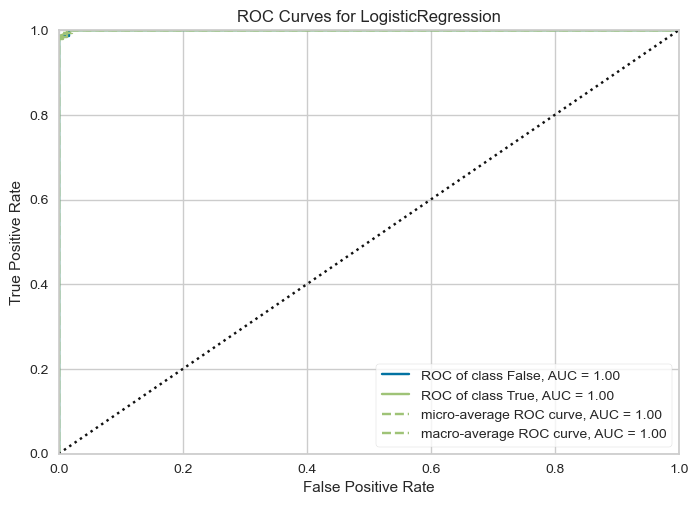

accuracy: 0.993
f1_score: 0.992


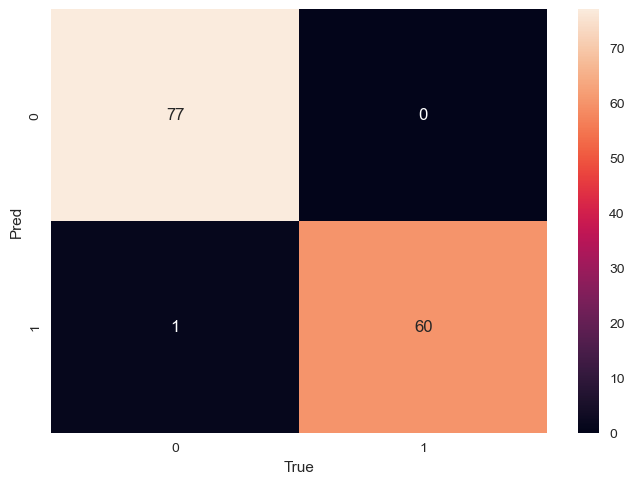

In [18]:
# LogisticRegression
model = LogisticRegression(max_iter = 1000)
train_model(model)

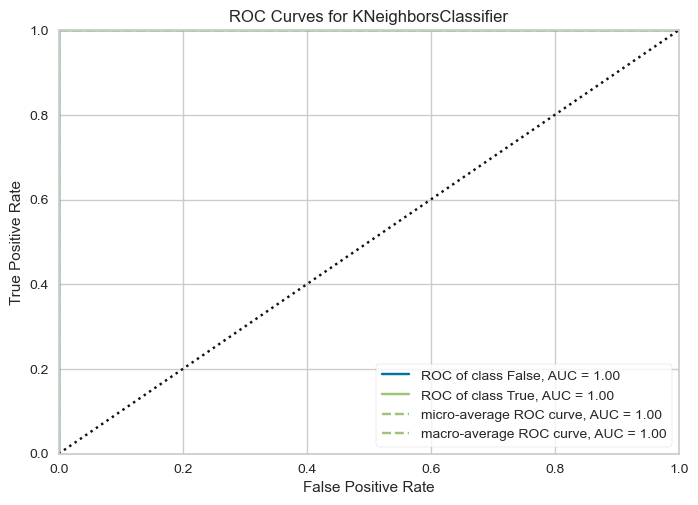

accuracy: 1.0
f1_score: 1.0


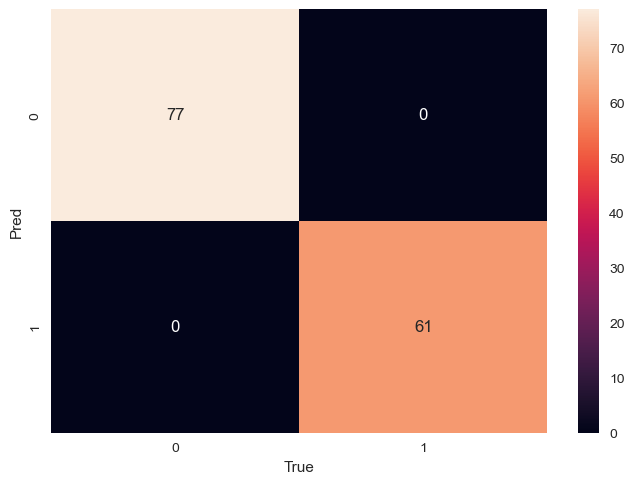

In [19]:
# KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3)
train_model(model)

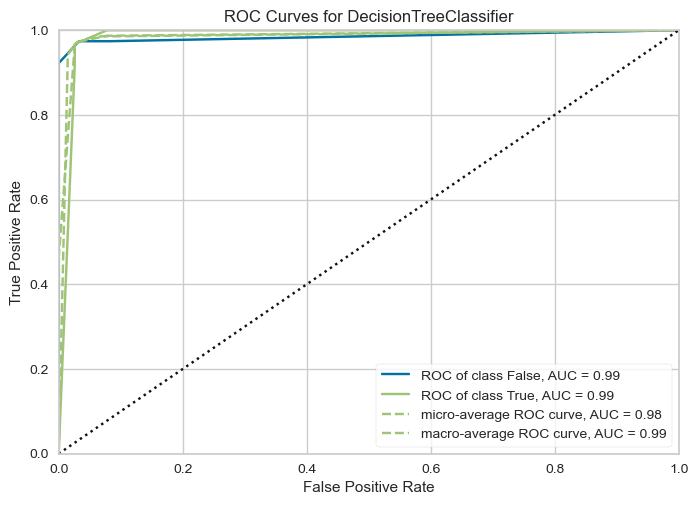

accuracy: 0.971
f1_score: 0.967


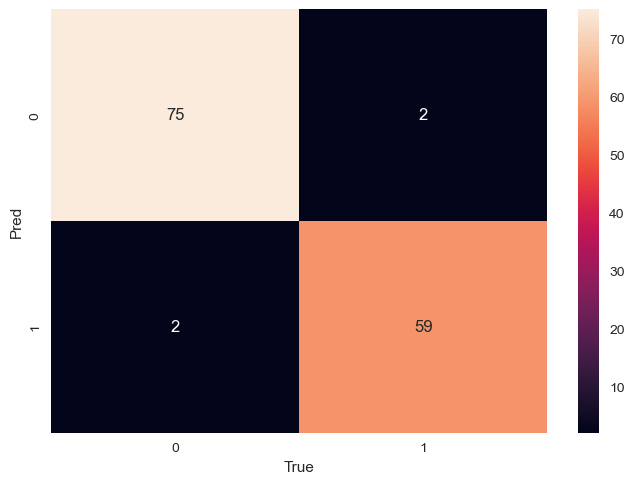

In [20]:
# DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 5)
train_model(model)

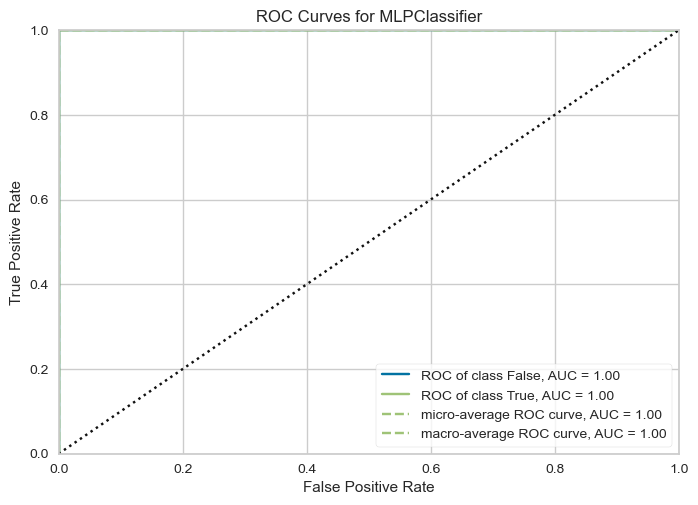

accuracy: 1.0
f1_score: 1.0


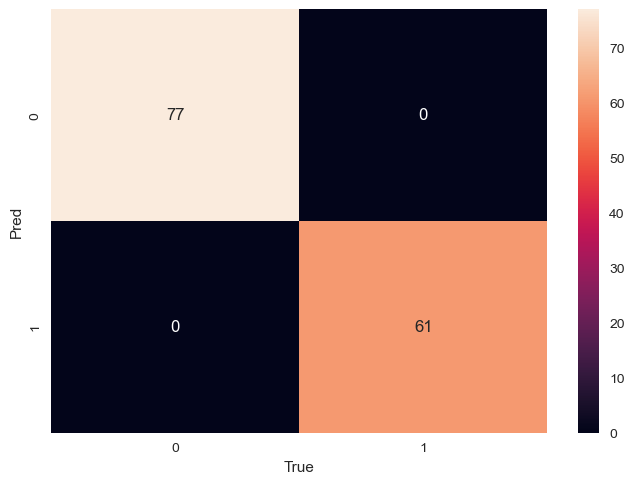

In [21]:
# MLPClassifier
model = MLPClassifier(max_iter = 1000)
train_model(model)

Кnn и MLPClassifier, смогли выдать максимальные точность и f1_score. Для диагностики возьмём самую простую из нейронных сетей - Перцептрон. Гиперпараметры же будем подбирать к Дереву Решений чтобы попытаться улучшить результат

**5. Проведите диагностику лучшей модели из пункта 4.**

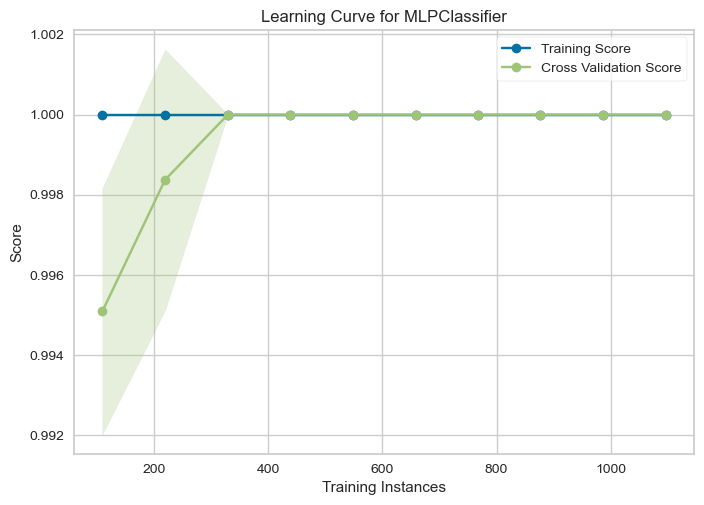

In [22]:
# cтроим кривую обучения - f1 по Перцептрону
visualizer = LearningCurve(
    MLPClassifier(max_iter = 1000), train_sizes=np.linspace(0.1, 1.0, 10), 
    scoring = make_scorer(f1_score)
).fit(X, y).show() # модель качественно обучилась

**6. Сделайте подбор гиперпараметров для лучшей модели из пункта 4.**

In [23]:
# параметры для GridSearch
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [i for i in range(1, 11)]}
base_model = DecisionTreeClassifier()

In [24]:
# GridSearch по Дереву Решений
grid_model = GridSearchCV(estimator = base_model,
                          param_grid = param_grid,
                          scoring = 'f1',
                          cv = 5,
                          verbose = 2)

In [25]:
# запускаем GridSearch
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1', verbose=2)

In [26]:
# Выводим лучший результат
grid_model.best_estimator_

DecisionTreeClassifier(max_depth=10)

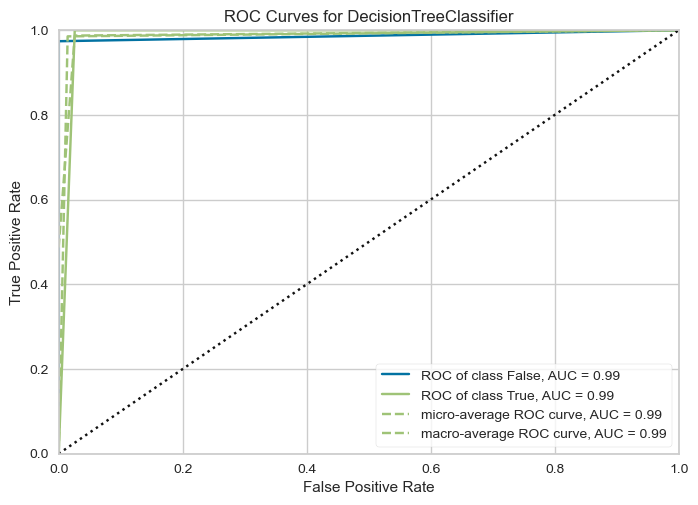

accuracy: 0.986
f1_score: 0.984


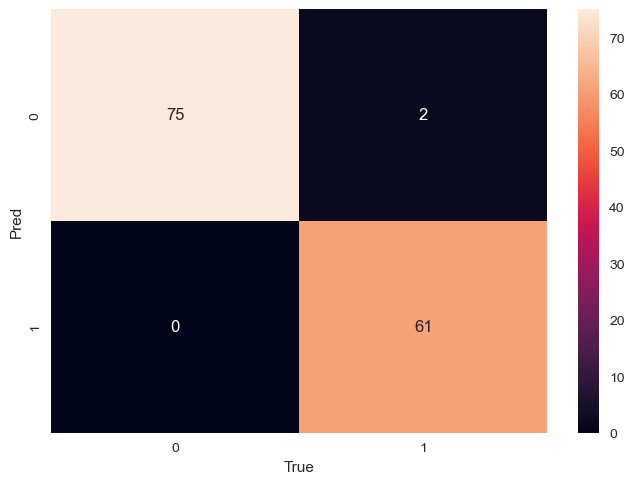

In [29]:
# DecisionTreeClassifier_best_params
model = DecisionTreeClassifier(max_depth = 10)
train_model(model)

Как мы видим, поиск по сетке действительно смог нам помочь улучшить модель DecisionTreeClassifier

**7. Постройте ансамблевую модель машинного обучения.**

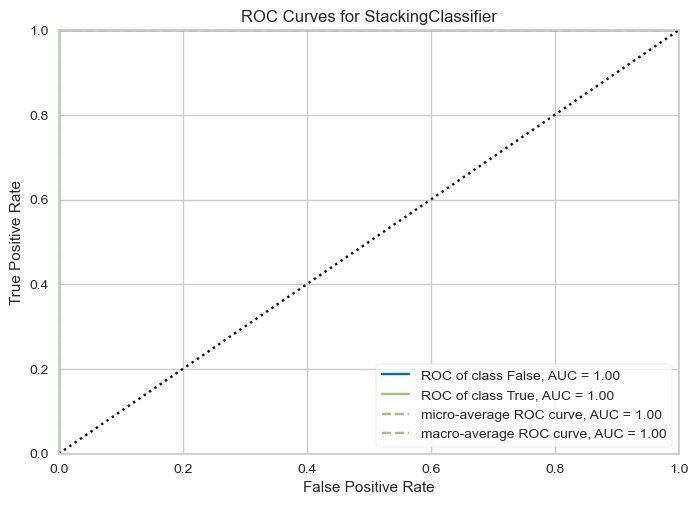

accuracy: 1.0
f1_score: 1.0


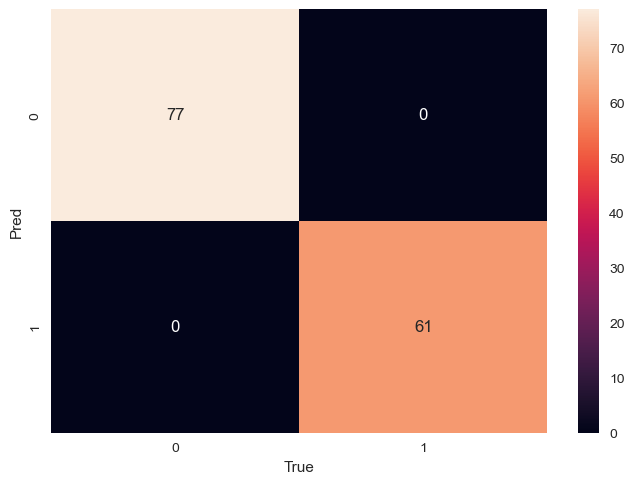

In [31]:
# построим ансамблевую модель из трёх "обычных"
estimators = [
    ('trees-1', DecisionTreeClassifier(max_depth = 5)),
    ('logreg', LogisticRegression(max_iter = 1000)),
    ('trees-2', DecisionTreeClassifier(max_depth = 10))
]
stacking_model = StackingClassifier(estimators = estimators, cv = 5)

train_model(stacking_model)

Три "неидеальные" модели вместе выдали максимальный возможный результат

# Вывод

*Данная работа помогла освежить знания, полученные в течение курса "Машинного Обучения". Было обучено несколько несложных моделей, с помощью поиска по сетке удалось поднять точность модели Дерева Решений, ансамбливая модель выдала максимальный результат, с помощью Feature selection из изначального датасета был убран атрибут Энтропии. Наилучшими моделями для проверки банкнот оказались KNN и Перцептрон*